<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/38_PyTorch_Siamese_Networks_Face_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **PyTorch - Facial Similarity with Siamese Networks in Pytorch**

---


In this lesson, we will implement **Facial Similarity with Siamese Networks in Pytorch** using PyTorch.

The goal is to teach a siamese network to be able to distinguish pairs of images. The outline of this lesson is below:

1. Load our modules, data and define some utlity functions
2. Setup our Data Processing - Create our Image Pairs
3. Building our Siamese Network
4. Start Training
5. View our Test Results

**Credits**:

You can read the accompanying article at https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e

Source - https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch

Note:
Any dataset can be used. Each class must be in its own folder. This is the same structure that PyTorch's own image folder dataset uses.

## **1. Load our modules, data and define some utlity functions**

In [ ]:
import os
import torch
import numpy as np
import random
import shutil
from PIL import Image
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

### **Create a simple image show and plotting function**

In [ ]:
# Parametrlar
BATCH_SIZE = 32
NUM_EPOCHS = 20
IMAGE_SIZE = 100
USE_GPU = torch.cuda.is_available()

### **Download our dataset - The AT&T Faces Dataset**
Source - https://www.kaggle.com/kasikrit/att-database-of-faces

In [ ]:
# Siamese tarmoq uchun ma'lumotlar to'plami klassini aniqlash
class SiameseDataset(Dataset):
    def __init__(self, image_paths, person_ids, transform=None):
        self.image_paths = image_paths
        self.person_ids = person_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Birinchi rasm
        img1_path = self.image_paths[idx]
        img1_id = self.person_ids[idx]

        # 50% ehtimol bilan bir xil odam, 50% ehtimol bilan boshqa odam
        same_person = random.random() > 0.5

        if same_person:
            # Bir xil odam (lekin boshqa fayl)
            same_id_idxs = [i for i, id in enumerate(self.person_ids) if id == img1_id and i != idx]
            if len(same_id_idxs) == 0:  # Agar bir xil person_id li boshqa rasm bo'lmasa
                same_person = False  # Boshqa odamga o'tish
            else:
                img2_idx = random.choice(same_id_idxs)
                img2_path = self.image_paths[img2_idx]
                img2_id = self.person_ids[img2_idx]

        if not same_person:
            # Boshqa odam
            diff_id_idxs = [i for i, id in enumerate(self.person_ids) if id != img1_id]
            if diff_id_idxs:
                img2_idx = random.choice(diff_id_idxs)
                img2_path = self.image_paths[img2_idx]
                img2_id = self.person_ids[img2_idx]
            else:
                # Boshqa odam topilmadi - yana o'z rasmini ishlatish
                img2_idx = idx
                img2_path = img1_path
                img2_id = img1_id
                same_person = True

        # Rasmlarni yuklash
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        # Transformatsiya
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Etiketlash: 0 - bir xil odam, 1 - boshqa odam (Siamese tarmoq uchun)
        label = torch.FloatTensor([1.0]) if img1_id != img2_id else torch.FloatTensor([0.0])

        return img1, img2, label

### **Create a class that stores our parameters**

In [ ]:
# Siamese tarmoq modelini aniqlash
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Rasmning o'lchami: 100x100 -> 50x50 -> 25x25 -> 12x12 -> 6x6
        # 256 kanallar * 6 * 6 = 9216
        self.fc = nn.Sequential(
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, img1, img2):
        feat1 = self.forward_once(img1)
        feat2 = self.forward_once(img2)
        return feat1, feat2

## **2. Setup our Data Processing - Create our Image Pairs**

In [ ]:
# Contrastive Loss funksiyasi
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

### **Set out image Folders**

In [ ]:
# Ma'lumotlar to'plamini tayyorlash funktsiyasi
def prepare_fei_dataset(dataset_path, image_size=100):
    """
    FEI-Face ma'lumotlar to'plamini Siamese tarmoq uchun tayyorlash
    """
    print(f"Ma'lumotlar to'plamini tayyorlash: {dataset_path}")

    # Ma'lumotlar to'plami yo'lini tekshirish
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Ma'lumotlar to'plami yo'li topilmadi: {dataset_path}")

    # Barcha rasmlarni rekursiv qidiruv orqali topish
    image_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        raise FileNotFoundError(f"Ma'lumotlar to'plamida rasmlar topilmadi: {dataset_path}")

    print(f"Topilgan rasmlar soni: {len(image_paths)}")

    # FEI-Face ma'lumotlar to'plamida har bir odam ID raqami bilan belgilangan
    # Masalan: 1-01.jpg, 1-02.jpg - bu 1-ID li odamning rasmlari
    person_ids = []
    for path in image_paths:
        filename = os.path.basename(path)
        # Fayl nomidan person ID ni ajratib olish
        person_id = filename.split('-')[0]
        if not person_id.isdigit():
            person_id = os.path.basename(os.path.dirname(path))
        person_ids.append(person_id)

    unique_persons = set(person_ids)
    print(f"Noyob odamlar soni: {len(unique_persons)}")

    # Train va test uchun ma'lumotlarni ajratish (80% train, 20% test)
    person_to_images = {}
    for person_id in unique_persons:
        person_to_images[person_id] = [i for i, p_id in enumerate(person_ids) if p_id == person_id]

    train_indices = []
    test_indices = []
    for person_id, indices in person_to_images.items():
        random.shuffle(indices)
        split_idx = max(1, int(len(indices) * 0.8))
        train_indices.extend(indices[:split_idx])
        test_indices.extend(indices[split_idx:])

    print(f"Train uchun rasmlar soni: {len(train_indices)}")
    print(f"Test uchun rasmlar soni: {len(test_indices)}")

    # Train va test ma'lumotlarini tayyorlash
    train_image_paths = [image_paths[i] for i in train_indices]
    train_person_ids = [person_ids[i] for i in train_indices]

    test_image_paths = [image_paths[i] for i in test_indices]
    test_person_ids = [person_ids[i] for i in test_indices]

    # Transformatsiyalarni yaratish
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    # Ma'lumotlar to'plamlarini yaratish
    train_dataset = SiameseDataset(train_image_paths, train_person_ids, transform)
    test_dataset = SiameseDataset(test_image_paths, test_person_ids, transform)

    return train_dataset, test_dataset

### **Create our transformers**

In [ ]:
# Model o'qitish funktsiyasi
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=20):
    device = torch.device("cuda" if USE_GPU else "cpu")
    print(f"Qurilma: {device}")

    model = model.to(device)

    # Log qaydlari uchun
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # TRAINING
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            img1, img2, label = data
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()

            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Har 10 ta batch dan so'ng natijalarni ko'rsatish
            if i % 10 == 9:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {i+1}, Loss: {running_loss/10:.4f}')
                running_loss = 0.0

        # TESTING
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:
                img1, img2, label = data
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                output1, output2 = model(img1, img2)
                loss = criterion(output1, output2, label)

                test_loss += loss.item()

                # O'xshashlik darajasini hisoblash
                euclidean_distance = F.pairwise_distance(output1, output2)

                # Threshold 1.0 (bu parametrni o'zgartirish mumkin)
                predictions = (euclidean_distance > 1.0).float()
                correct += (predictions == label.squeeze()).sum().item()
                total += label.size(0)

        epoch_test_loss = test_loss / len(test_loader)
        accuracy = 100 * correct / total

        print(f'Epoch: {epoch+1}/{num_epochs}, Test Loss: {epoch_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

        # Loglarni saqlash
        train_losses.append(running_loss)
        test_losses.append(epoch_test_loss)

    return train_losses, test_losses

### **Create our Data Loader and View some sample Images**

In [ ]:
# Natijalarni ko'rsatish
def visualize_results(model, test_loader, num_samples=5):
    device = torch.device("cuda" if USE_GPU else "cpu")
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            if i >= num_samples:
                break

            img1, img2, label = data
            img1, img2 = img1.to(device), img2.to(device)

            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)

            img1_np = img1.cpu().numpy().transpose(0, 2, 3, 1)[0]
            img2_np = img2.cpu().numpy().transpose(0, 2, 3, 1)[0]

            # Agar rasm oq-qora bo'lsa (1 kanal)
            if img1_np.shape[2] == 1:
                img1_np = img1_np.squeeze()
                img2_np = img2_np.squeeze()

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img1_np)
            plt.title('Birinchi rasm')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(img2_np)
            plt.title('Ikkinchi rasm')
            plt.axis('off')

            is_same = "Bir xil odam" if label.item() == 0 else "Boshqa odam"
            similarity = f"Masofa: {euclidean_distance.item():.2f}"
            plt.suptitle(f"Haqiqatda: {is_same}\n{similarity}")

            plt.tight_layout()
            plt.show()


## **3. Building our Siamese Network**

In [ ]:
# Kaggle ma'lumotlar to'plami yo'lini ko'rsating
dataset_path = "/kaggle/input/fei-face-data"

## **Define our Contrastive Loss Function**

In [ ]:
# Ma'lumotlar to'plamini tayyorlash
train_dataset, test_dataset = prepare_fei_dataset(dataset_path, IMAGE_SIZE)

# Data loader yaratish
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Model, optimizer va loss funksiyasini yaratish
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Ma'lumotlar to'plamini tayyorlash: /kaggle/input/fei-face-data
Topilgan rasmlar soni: 2800
Noyob odamlar soni: 200
Train uchun rasmlar soni: 2200
Test uchun rasmlar soni: 600


### **Make our Training Data Loader**

In [ ]:
# Model o'qitish
train_losses, test_losses = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=NUM_EPOCHS
)

Qurilma: cuda
Epoch: 1/20, Batch: 10, Loss: 1.0718
Epoch: 1/20, Batch: 20, Loss: 0.5355
Epoch: 1/20, Batch: 30, Loss: 0.3125
Epoch: 1/20, Batch: 40, Loss: 0.3325
Epoch: 1/20, Batch: 50, Loss: 0.4008
Epoch: 1/20, Batch: 60, Loss: 0.3805
Epoch: 1/20, Test Loss: 0.3261, Accuracy: 91.33%
Epoch: 2/20, Batch: 10, Loss: 0.3686
Epoch: 2/20, Batch: 20, Loss: 0.2867
Epoch: 2/20, Batch: 30, Loss: 0.2945
Epoch: 2/20, Batch: 40, Loss: 0.2405
Epoch: 2/20, Batch: 50, Loss: 0.2256
Epoch: 2/20, Batch: 60, Loss: 0.3389
Epoch: 2/20, Test Loss: 0.3141, Accuracy: 92.17%
Epoch: 3/20, Batch: 10, Loss: 0.3046
Epoch: 3/20, Batch: 20, Loss: 0.2337
Epoch: 3/20, Batch: 30, Loss: 0.2154
Epoch: 3/20, Batch: 40, Loss: 0.2018
Epoch: 3/20, Batch: 50, Loss: 0.2100
Epoch: 3/20, Batch: 60, Loss: 0.1926
Epoch: 3/20, Test Loss: 0.2332, Accuracy: 94.50%
Epoch: 4/20, Batch: 10, Loss: 0.2469
Epoch: 4/20, Batch: 20, Loss: 0.2716
Epoch: 4/20, Batch: 30, Loss: 0.3076
Epoch: 4/20, Batch: 40, Loss: 0.2700
Epoch: 4/20, Batch: 50, L

### **Define our Loss and Optimizer before training**

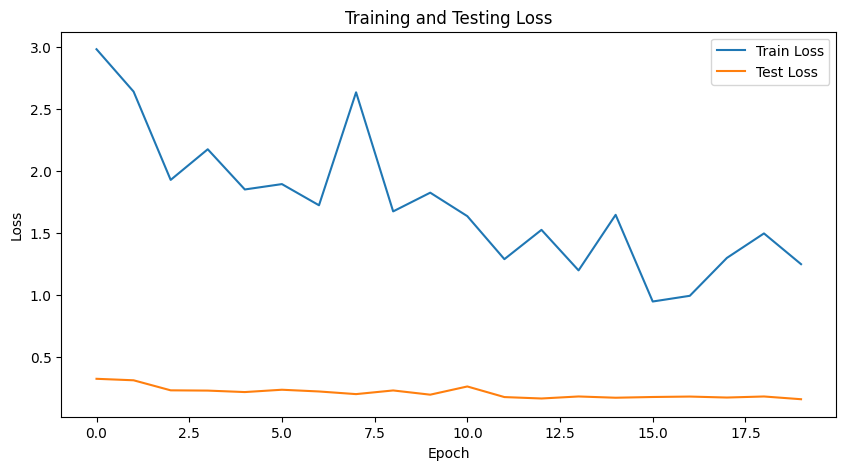

In [ ]:
# Natijalarni ko'rsatish
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

## **4. Start Training**

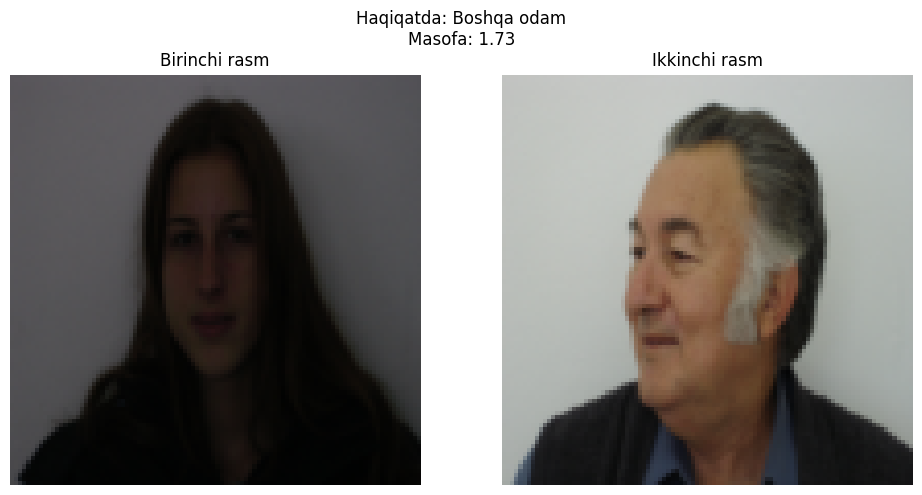

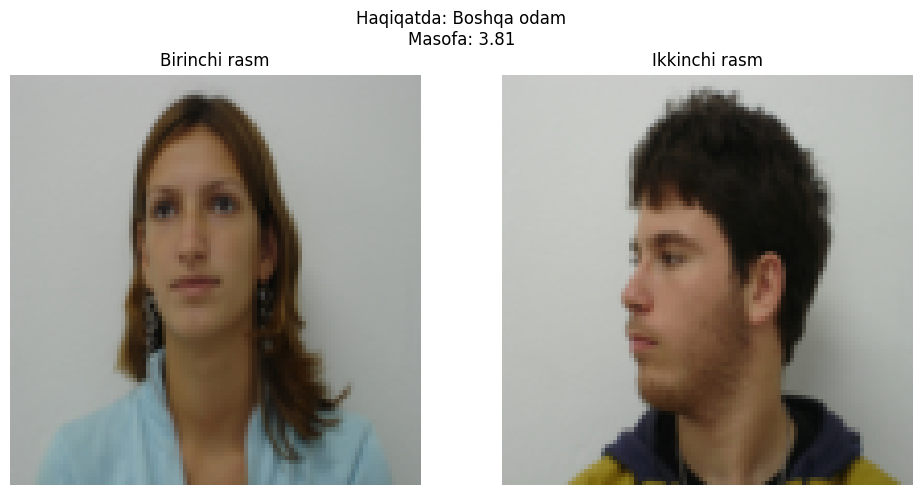

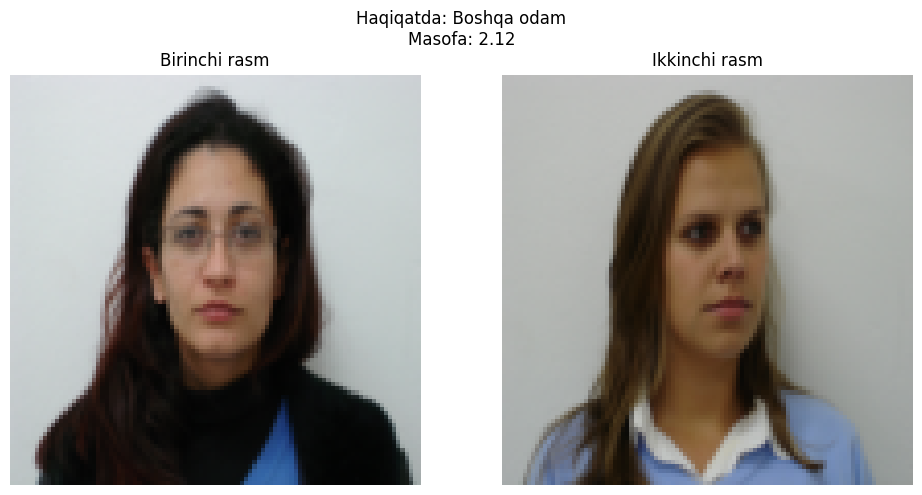

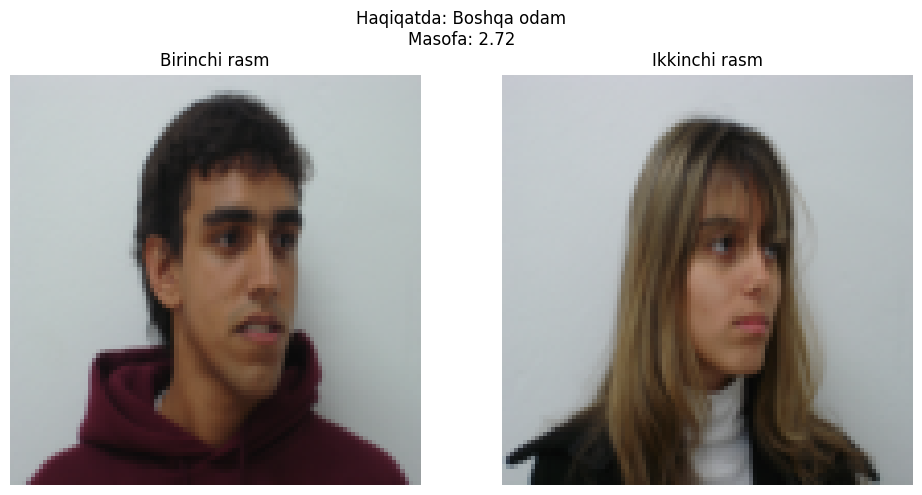

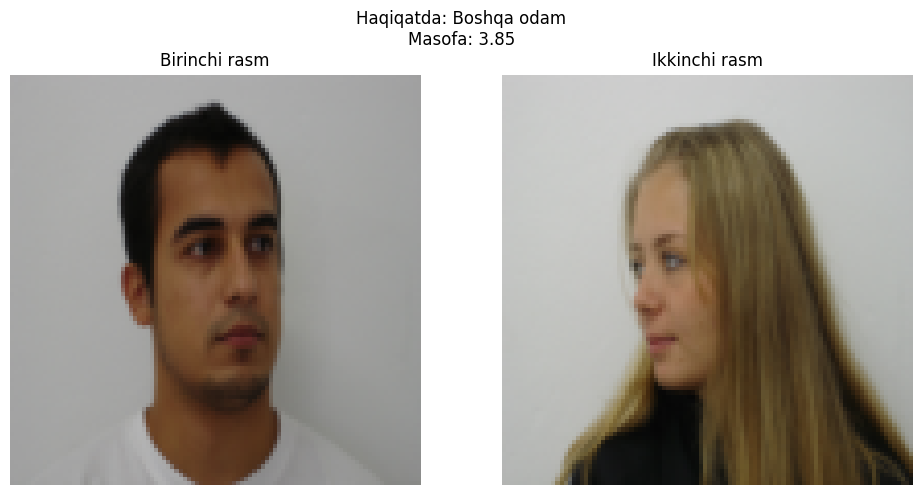

In [ ]:
# Test ma'lumotlarida ba'zi natijalarni ko'rsatish
visualize_results(model, DataLoader(test_dataset, batch_size=1, shuffle=True), num_samples=5)

## **5. View our Test Results**

The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [ ]:
# Modelni saqlash
torch.save(model.state_dict(), 'siamese_face_model.pth')
print("Model muvaffaqiyatli saqlandi: siamese_face_model.pth")

Model muvaffaqiyatli saqlandi: siamese_face_model.pth
